<a href="https://colab.research.google.com/github/newguy7/DataScienceProjects/blob/main/pharmaceutical_inventory_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


# # Create a function to generate seasonality effect
# def generate_seasonality(days):
#     return 10 * np.sin(2 * np.pi * days.dayofyear / 365.25)

# # Create a function to generate trend effect
# def generate_trend(days):
#     return 0.01 * (days - days.min()).days

# Load the dataset
df = pd.read_csv('pharmaceutical_inventory_forecasting.csv')

# # Apply seasonality and trend effects
# df['Seasonality'] = generate_seasonality(df['Date'])
# df['Trend'] = generate_trend(df['Date'])
# df['Sales'] = df['Sales'] + df['Seasonality'] + df['Trend']

# # Simulate promotions or holidays (random events)
# promotion_days = pd.date_range(start='2022-01-01', end='2024-01-01', freq='M')
# for promotion_day in promotion_days:
#     df.loc[df['Date'] == promotion_day, 'Sales'] += np.random.poisson(lam=100, size=len(df[df['Date'] == promotion_day]))

# df['Reorder_Quantity'] = np.random.poisson(lam=60, size=len(days) * num_products * num_warehouses)

df.head()


,Date,Product_ID,Warehouse_ID,Stock_Level,Sales,Seasonality,Trend,Reorder_Quantity
0,2023-07-26,92,10,553,51.638705,-4.071295,5.71,50
1,2023-01-13,85,9,552,55.987722,2.217722,3.77,62
2,2022-05-30,27,3,470,53.812271,5.322271,1.49,52
3,2023-10-13,14,2,510,45.714519,-9.785481,6.50,61
4,2023-08-19,82,9,517,44.556077,-7.393923,5.95,62


###Data Cleaning

In [ ]:
# Check for missing values
df.isnull().sum()

# Check for duplicates
df.duplicated().sum()

# Convert 'Date' to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Ensure all other columns are of the correct type
df.dtypes


Date                datetime64[ns]
Product_ID                   int64
Warehouse_ID                 int64
Stock_Level                  int64
Sales                      float64
Seasonality                float64
Trend                      float64
Reorder_Quantity             int64
dtype: object

###Feature Engineering

In [ ]:
# Create date-related features
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# Create lag features
df['Lagged_Sales_1'] = df.groupby(['Product_ID', 'Warehouse_ID'])['Sales'].shift(1)
df['Lagged_Sales_7'] = df.groupby(['Product_ID', 'Warehouse_ID'])['Sales'].shift(7)
df['Lagged_Stock_Level_1'] = df.groupby(['Product_ID', 'Warehouse_ID'])['Stock_Level'].shift(1)

# Fill NaN values in lag features
df.fillna(0, inplace=True)


# Create rolling average features
df['Rolling_Sales_7'] = df.groupby(['Product_ID', 'Warehouse_ID'])['Sales'].rolling(window=7).mean().reset_index(level=['Product_ID', 'Warehouse_ID'], drop=True)
df['Rolling_Sales_30'] = df.groupby(['Product_ID', 'Warehouse_ID'])['Sales'].rolling(window=30).mean().reset_index(level=['Product_ID', 'Warehouse_ID'], drop=True)

df.fillna(0, inplace=True)


###Model Training

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target variable
features = ['Day_of_Week', 'Month', 'Quarter', 'Lagged_Sales_1', 'Lagged_Sales_7', 'Lagged_Stock_Level_1', 'Rolling_Sales_7', 'Rolling_Sales_30', 'Seasonality', 'Trend']
target = 'Sales'

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)

# Train the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(train_df[features], train_df[target])

# Make predictions
test_df['Predicted_Sales'] = model.predict(test_df[features])

# Evaluate the model
mse = mean_squared_error(test_df[target], test_df['Predicted_Sales'])
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(test_df[target], test_df['Predicted_Sales'])
print(f'r2_Score: {r2}')


RMSE: 7.833914086868132
r2_Score: 0.850010719591666


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_df[features], train_df[target])

# Make predictions
test_df['Predicted_Sales'] = model.predict(test_df[features])

# Evaluate the model
mse = mean_squared_error(test_df[target], test_df['Predicted_Sales'])
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(test_df[target], test_df['Predicted_Sales'])
print(f'r2_Score: {r2}')


RMSE: 7.556778739410741
r2_Score: 0.8604351588938063


In [ ]:
test_df[['Sales','Predicted_Sales']].head()

,Sales,Predicted_Sales
40000,67.603322,51.741590
40001,53.346933,50.291831
40002,61.084028,56.027694
40003,49.552969,47.489845
40004,53.537195,57.921780


###Model Testing and Evaluation

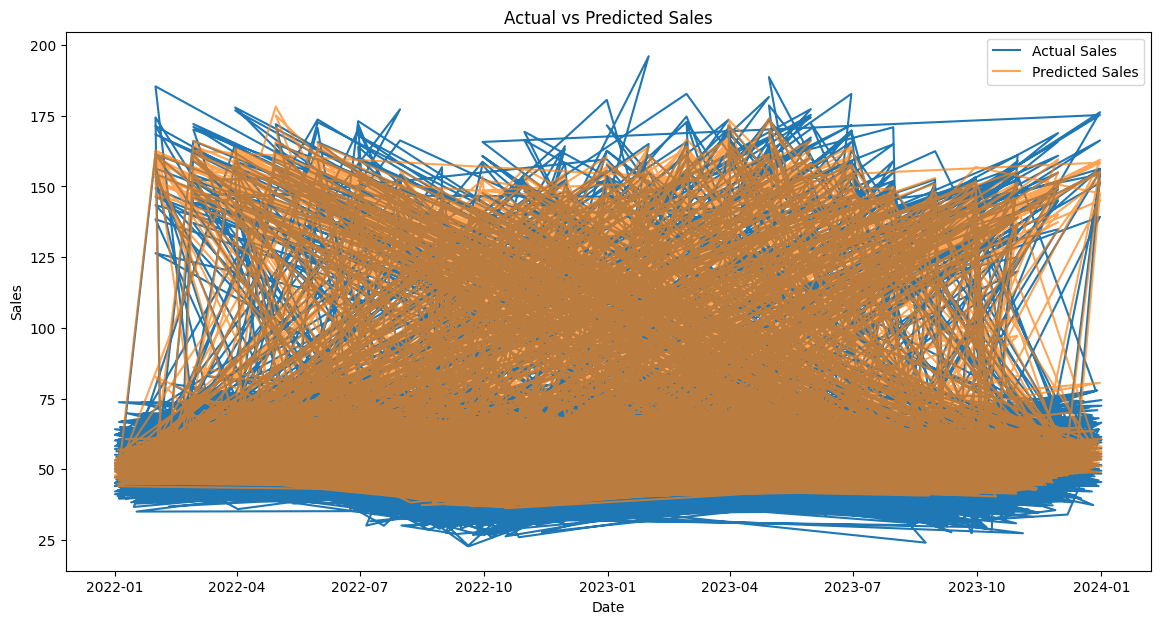

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(test_df['Date'], test_df['Sales'], label='Actual Sales')
plt.plot(test_df['Date'], test_df['Predicted_Sales'], label='Predicted Sales', alpha=0.7)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.show()
